In [1]:
import aomip
import numpy as np
import json
from os.path import join
from tifffile import imsave, imread
import matplotlib.pyplot as plt
import GradientDescent
from challenge import utils
from scipy.fft import fftshift, ifftshift, fft
from utils import save_array_as_image, plot_convergence, filter_sinogram
from Operator import forward_diff, backward_diff, central_diff

pyelsa not build with CUDA projector support


[2023-06-25 10:21:17.984] [phantom::modifiedSheppLogan] [info] creating modified Shepp Logan phantom of size 512^2
[2023-06-25 10:21:18.045] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 512 poses in an 360 degree arc
(384000, 262144)


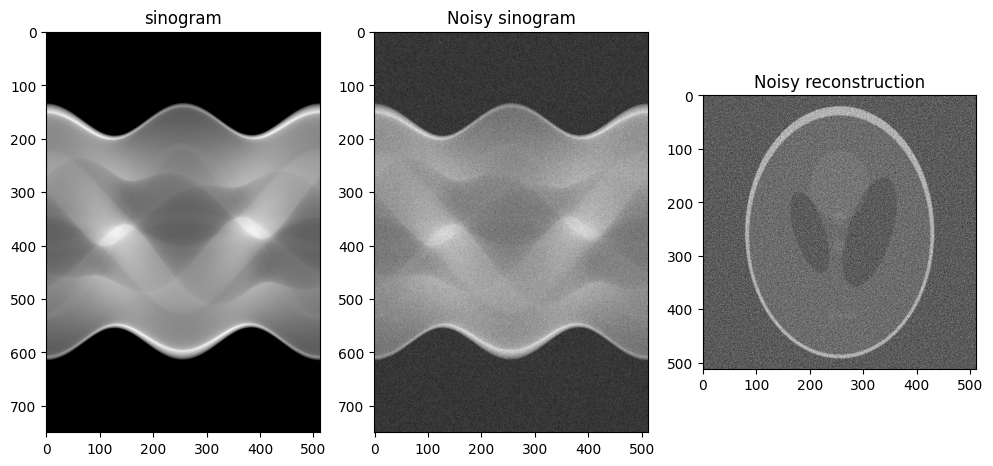

In [3]:
size = np.array([512, 512])
phantom = aomip.shepp_logan(size)
num_angles = 512
arc = 360

A = aomip.XrayOperator(size, [750], np.linspace(0, arc, num_angles), size[0]*100, size[0]*2)
sinogram = A.apply(phantom)
gaussian_noise = np.random.normal(0, 10, sinogram.shape)     #add gaussian noise
noisy_sinogram = sinogram + gaussian_noise
print(A.shape)
###################### Filter ##############################################
H = np.linspace(-1, 1, noisy_sinogram.shape[0])

ram_lak = np.abs(H)
shepp_logan = np.abs(H) * np.sinc(H / 2)
cosine = np.abs(H) * np.cos(H * np.pi / 2)

h = np.tile(shepp_logan, (512, 1)).T
fftsino = np.fft.fft(noisy_sinogram, axis=0)
projection = np.fft.fftshift(fftsino, axes=1) * np.fft.fftshift(h, axes=0)
fsino = np.real(np.fft.ifft(np.fft.ifftshift(projection, axes=1), axis=0))
###################### Filter ##############################################

img_vector = 512*512
x0 = np.random.rand(img_vector)
b = fsino.flatten()
groundtruth = phantom.flatten()

filtered_backprojection = A.applyAdjoint(fsino)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1, title="sinogram");plt.imshow(sinogram,cmap='gray')
plt.subplot(1,3,2, title="Noisy sinogram");plt.imshow(noisy_sinogram,cmap='gray')
plt.subplot(1,3,3, title="Noisy reconstruction");plt.imshow(filtered_backprojection,cmap='gray')
plt.show()

iteration cg: 10


/var/folders/pb/tb9th22s1bg2w5j250zz59s80000gn/T/ipykernel_43046/780016866.py:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave(join('img','exp4.tif'), cg)


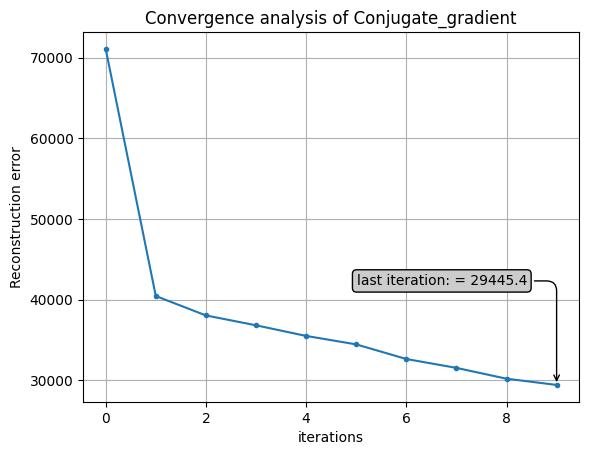

In [14]:
cg, itr, history = GradientDescent.conjugate_gradient_normal(A,b,x0,iteration=10)
cg= cg.reshape((512,512))
print('iteration cg:',itr)
imsave(join('img','exp4.tif'), cg)
plot_convergence(groundtruth,history,itr,'Conjugate_gradient','img')

### Homework 3: Challenge Dataset

[2023-06-07 18:18:46.011] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 180 poses in an 89.5 degree arc


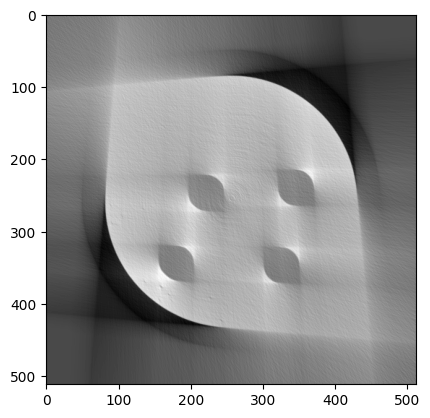

In [2]:
with open("config.json", "r") as json_data_file:
    data = json.load(json_data_file)
dataset = data["htc"]
data_path = (dataset["data_path"])["local"]
file_name = dataset["phantom1b"]
file = join(data_path,file_name)

# limited angle sinogram 90 degrees
sinogram, A = utils.load_htc2022data(file,arc=90)
fsino = filter_sinogram(sinogram,'shepp-logan')
b = fsino.flatten()

fbp = A.applyAdjoint(fsino)
plt.imshow(fbp,cmap='gray')

In [6]:
sinogram.shape

(560, 180)

iteration backtrack: 20


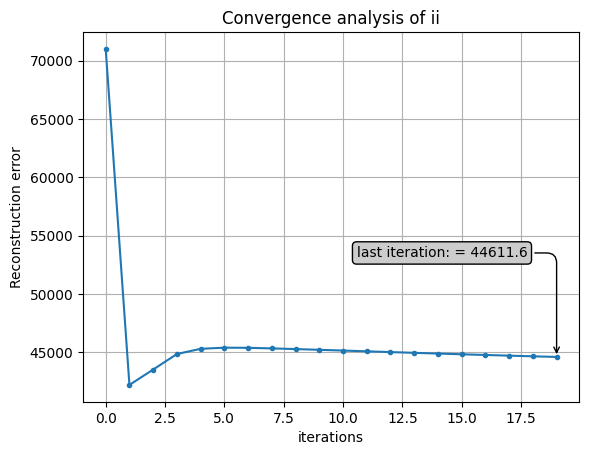

In [35]:
x0 = np.random.rand(img_vector)

xBacktrack, itr, history = GradientDescent.backtracking_linesearch(A,b,x0,1e-3,0.1,0.1,eps=1e-6,iteration=20)
xBacktrack = xBacktrack.reshape((512,512))
print('iteration backtrack:',itr)
plt.imshow(xBacktrack,cmap='gray')
plot_convergence(groundtruth,history,itr,'ii','img')

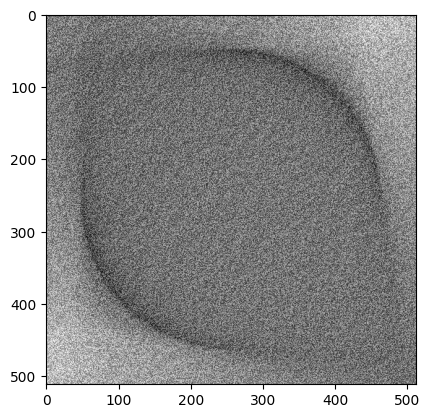

In [36]:
plt.imshow(xBacktrack,cmap='gray')

In [4]:
groundtruth_path = dataset["groundtruth1b"]
groundtruth = imread(groundtruth_path)
recon_path = join("/Users/boeykaizhe/Documents/TUM/ftp/hw04/img3","exp1.tif")
recon = imread(recon_path)
recon2 = imread(recon_path)
score=utils.calculate_score(recon,groundtruth)
print('score: ',score)

score:  0


### Homework 4: Catch up

[2023-06-09 11:04:27.154] [phantom::modifiedSheppLogan] [info] creating modified Shepp Logan phantom of size 512^2
[2023-06-09 11:04:27.223] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 512 poses in an 360 degree arc


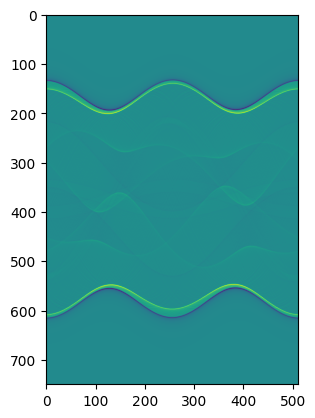

In [7]:
size = np.array([512, 512])
phantom = aomip.shepp_logan(size)
num_angles = 512
arc = 360

A = aomip.XrayOperator(size, [750], np.linspace(0, arc, num_angles), size[0]*100, size[0]*2)
sinogram = A.apply(phantom)
fsino = filter_sinogram(sinogram,'shepp-logan')
b = fsino.flatten()
plt.imshow(fsino)

In [5]:
fdm = forward_diff(5)
print(fdm.toarray())

bdm = backward_diff(5)
print(bdm.toarray())

cdm = central_diff(5)
print(cdm.toarray())

[[-1  1  0  0  0]
 [ 0 -1  1  0  0]
 [ 0  0 -1  1  0]
 [ 0  0  0 -1  1]
 [ 0  0  0  0  0]]
[[ 0  0  0  0  0]
 [-1  1  0  0  0]
 [ 0 -1  1  0  0]
 [ 0  0 -1  1  0]
 [ 0  0  0 -1  1]]
[[ 0.   0.   0.   0.   0. ]
 [-0.5  0.   0.5  0.   0. ]
 [ 0.  -0.5  0.   0.5  0. ]
 [ 0.   0.  -0.5  0.   0.5]
 [ 0.   0.   0.   0.   0. ]]


Perform a Gradient descent experiment with tikhonov regularization with forward, backward and central difference